In [2]:
import rawpy
import imageio
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import numpy as np
from torchvision import models
from matplotlib import pyplot as plt
import torch
from torchsummary import summary
from collections import defaultdict
import torch.nn.functional as F
import torch
from torchsummary import summary
import torch
import torch.nn as nn
# from loss import dice_loss
from tqdm import tqdm
import random
import pickle

In [2]:
with open('/home/ad/dng/raw_list.pkl','rb') as f:
    raw_list = pickle.load(f)
    raw_array = np.stack(raw_list)
    del raw_list
    raw_array[raw_array>255] = 255
    raw_array = raw_array.astype(np.float32)/255.0
with open('/home/ad/dng/rgb_list.pkl','rb') as f:
    rgb_list = pickle.load(f)
    rgb_array = np.stack(rgb_list)
    del rgb_list
    rgb_array = rgb_array.astype(np.float32)/255.0

In [3]:
torch.cuda.is_available()

/home/ad/venv/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


False

In [3]:
class SimDataset(Dataset):
    def __init__(self, raw_array, rgb_array,count, transform=None):
        # self.flist = []
        self.size = 64
        self.stride = 2
        self.count = count
        self.raw_array = raw_array
        self.rgb_array = rgb_array
        # for x in tqdm(path.iterdir()):
        #     if x.is_file():
        #         self.flist.append(x)
        #         raw = rawpy.imread(str(x))
        #         self.raw_list.append(raw.raw_image)
        #         self.rgb_list.append(raw.postprocess())

#         self.input_images, self.target_masks = simulation.generate_random_data(192, 192, count=count)        
        self.transform = transform
        self.source_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.479], [0.212]) # dng
        ])
        self.target_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
        ])
    def __len__(self):
        return self.count
    
    def __getitem__(self, idx):  
        stride = self.stride
        sample_num = idx%len(self.raw_array)
#         raw = rawpy.imread(str(self.flist[idx]))
        raw_image = self.raw_array[sample_num]
        rgb = self.rgb_array[sample_num]
        x = random.randint(0,int((raw_image.shape[0]-train_set.size-1)/stride))
        y = random.randint(0,int((raw_image.shape[1]-train_set.size-1)/stride))
        raw_crop = raw_image[stride*x:stride*x+self.size,stride*y:stride*y+self.size]
        rgb_crop = rgb[stride*x:stride*x+self.size,stride*y:stride*y+self.size]
#         if self.transform:
#             raw_image = self.transform(raw_image.astype(np.float32))
#             rgb = self.transform(rgb)
        return [self.source_transform(raw_crop), self.target_transform(rgb_crop),rgb_crop]


In [4]:
directory = Path('/content/intern_task')
train_set = SimDataset(raw_array,rgb_array, 1000)

In [5]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )

class ResNetUNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
        
        self.base_model = models.resnet18(pretrained=True)
        
        self.base_layers = list(base_model.children())                
        
        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0[0] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)        
        self.layer1_1x1 = convrelu(64, 64, 1, 0)       
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)        
        self.layer2_1x1 = convrelu(128, 128, 1, 0)  
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)        
        self.layer3_1x1 = convrelu(256, 256, 1, 0)  
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)  
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)
        
        self.conv_original_size0 = convrelu(1, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)
        
        layer0 = self.layer0(input)            
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)        
        layer4 = self.layer4(layer3)
        
        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        
        layer3 = self.layer3_1x1(layer3)
#         x = self.upsample(layer3)
#         print("x shape:",x.shape)
#         print("layer3 shape:",layer3.shape)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)
 
        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)
        
        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)        
        
        out = self.conv_last(x)        
        
        return out



In [6]:
model = torch.load('resnet18_64_4l_0508.pt')
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/ad/venv/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [114]:
        source_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.479], [0.212]) # dng
        ])
        target_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
        ])
        tensor_norm = transforms.Compose([
#         transforms.ToTensor(),
        transforms.Normalize([0.479], [0.212]) # dng
        ])

In [105]:
inp = source_transform(raw_array[0][:64,:64]).unsqueeze(0).to(device)

In [11]:
inp = train_set[0][0].unsqueeze(0)

In [12]:
out = model(inp.to(device))

In [13]:
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

In [ ]:
inv_normalize(out.detach().cpu()[0]).permute(1,2,0)

In [136]:
out.shape

torch.Size([1, 3, 64, 64])

In [150]:
inp,label, source = train_set[0]
with torch.no_grad():
    out = model(inp.unsqueeze(0).to(device))
plt.imshow(inv_normalize(out.detach().cpu()[0]).permute(1,2,0))

RuntimeError: CUDA error: unspecified launch failure

In [74]:
k = 10
big_raw = raw_array[k]
big_image = rgb_array[k]

In [118]:
tiles_tensors = torch.empty((rows*cols,64,64),dtype=torch.float32)
for rownum in range(rows):
    for colnum in  range(cols):
        tiles_tensors[rownum*cols+colnum] = torch.tensor(big_raw[size*rownum:size*(rownum+1),size*colnum:size*(colnum+1)])

In [132]:
tiles_tensors.shape

torch.Size([2961, 64, 64])

In [133]:
out_tensors = torch.empty((rows*cols,64,64,3),dtype=torch.float32)

In [134]:
out.shape

torch.Size([128, 3, 64, 64])

In [140]:
out_tensors.shape

torch.Size([2961, 64, 64, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


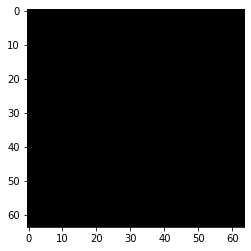

In [148]:
plt.imshow(inv_normalize(out.detach().cpu()[0]).permute(1,2,0))

0
torch.Size([128, 64, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


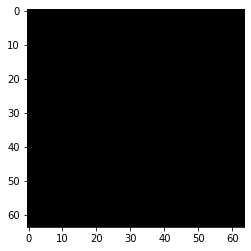

1
torch.Size([128, 64, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


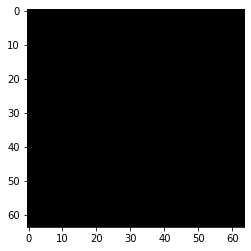

2
torch.Size([128, 64, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


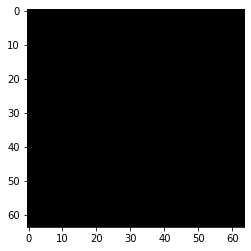

3
torch.Size([128, 64, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


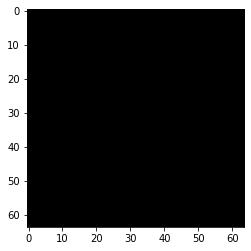

4
torch.Size([128, 64, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


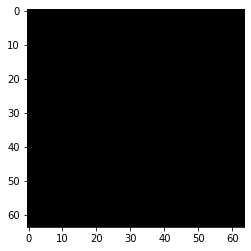

5
torch.Size([128, 64, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


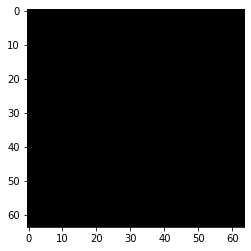

6
torch.Size([128, 64, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


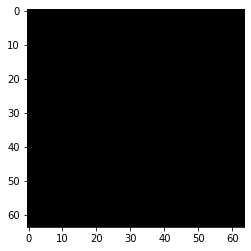

7
torch.Size([128, 64, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


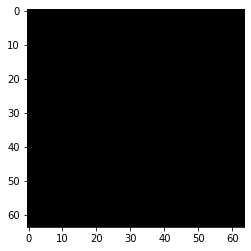

8
torch.Size([128, 64, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


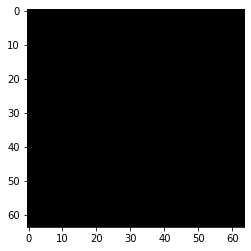

9
torch.Size([128, 64, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


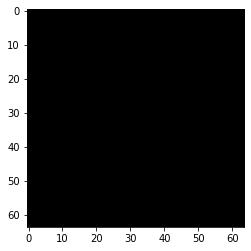

10
torch.Size([128, 64, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


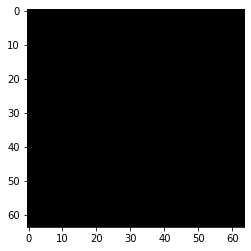

11
torch.Size([128, 64, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


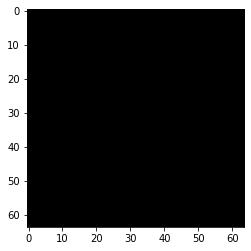

12
torch.Size([128, 64, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


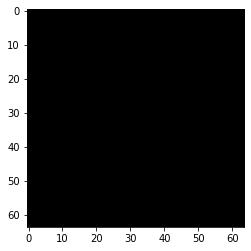

13
torch.Size([128, 64, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


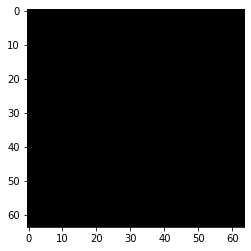

14
torch.Size([128, 64, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


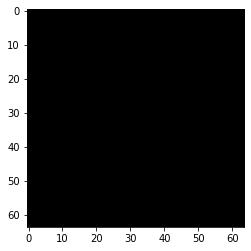

15
torch.Size([128, 64, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


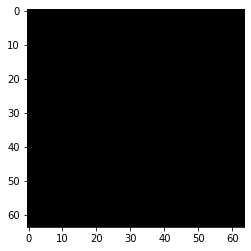

16
torch.Size([128, 64, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


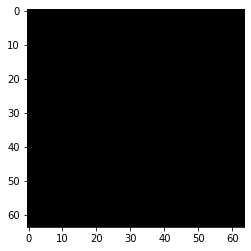

17
torch.Size([128, 64, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


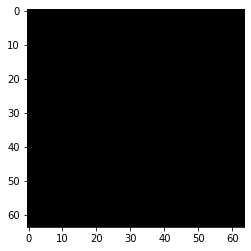

18
torch.Size([128, 64, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


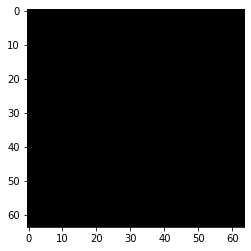

19
torch.Size([128, 64, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


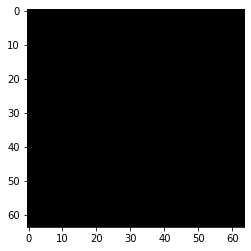

20
torch.Size([128, 64, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


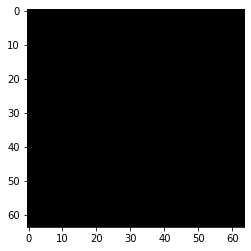

21
torch.Size([128, 64, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


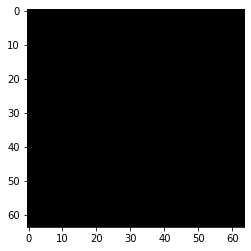

22
torch.Size([128, 64, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


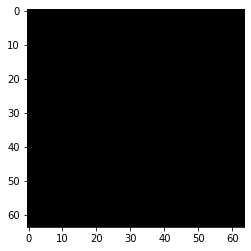

In [149]:
batch_size = 128
with torch.no_grad():
    for i in range(int(rows*cols/batch_size)):
        print(i)
        batch = tiles_tensors[i*batch_size:(i+1)*batch_size]
        print(batch.shape)
        batch[batch>255] = 255
        batch = batch/255.0
        inp = tensor_norm(batch).unsqueeze(1).to(device)
        out = model(inp.to(device))
        out_tensors[i*batch_size:(i+1)*batch_size] = inv_normalize(out.detach().cpu()[0]).permute(1,2,0)
        plt.imshow(inv_normalize(out.detach().cpu()[0]).permute(1,2,0))
        plt.show()
    

In [113]:
batch.shape

(32, 64, 64)

In [ ]:
tensor_norm(batch).shape

In [81]:
rownum = 0
colnum = 0
big_raw[size*rownum:size*(rownum+1),size*colnum:size*(colnum+1)].shape

(64, 64)

In [42]:
size = 64
rows = int(big_image.shape[0]/size)
cols = int(big_image.shape[1]/size)
rows,cols

(47, 63)

In [43]:
a = [3,4,6,5,7,8,6,45,66,47]
a[-2:]

[66, 47]

In [53]:
rows*cols

2961

In [63]:
batches = torch.split(tiles_tensors,32)

AttributeError: 'tuple' object has no attribute 'size'

In [ ]:
right_side = big_image[:,-size:]
right_side

In [ ]:
bottom = big_image[-size:]
bottom

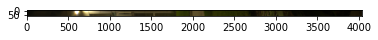

In [49]:
plt.imshow(bottom)

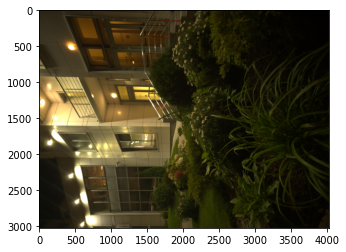

In [33]:
plt.imshow(big_image)